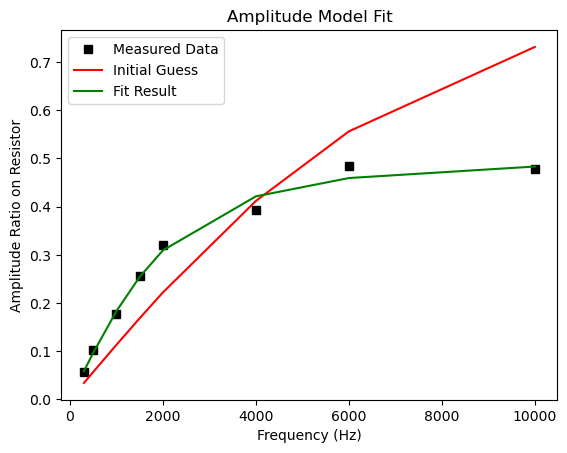

[[Model]]
    Model(amplitude)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 8
    # variables        = 2
    chi-square         = 0.00167345
    reduced chi-square = 2.7891e-04
    Akaike info crit   = -63.7784836
    Bayesian info crit = -63.6196005
    R-squared          = 0.99108218
[[Variables]]
    C:   3.4550e-11 +/- 1.8228e-12 (5.28%) (init = 2e-11)
    R:   1000000 (fixed)
    Rs:  1e+07 (fixed)
    Cs:  3.4760e-11 +/- 3.2176e-12 (9.26%) (init = 1e-12)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, Cs) = +0.8508


In [1]:
# Import necessary libraries
import numpy as np
import scipy.constants as scc  # Import physical constants like pico, mega, etc.
import lmfit  # Import lmfit for nonlinear curve fitting
from matplotlib import pyplot as plt  # Import Matplotlib for plotting

# Define the amplitude function that models the circuit response
def amplitude(w, C, R, Rs, Cs):
    '''
    Calculates the amplitude ratio A for an RC circuit in parallel with an oscilloscope.

    Parameters:
    w  : Angular frequency (rad/s), calculated as w = 2 * π * f
    C  : Load capacitance (F), which we may optimize during fitting
    R  : Load resistance (Ω), typically fixed in experiments
    Rs : Scope input resistance (Ω), typically large (e.g., 10 MΩ)
    Cs : Scope input capacitance (F), often a small value in pF range

    Returns:
    A  : Amplitude ratio (dimensionless), representing the voltage ratio 
         across the resistor in the circuit.
    '''
    # Compute the total parallel impedance of the scope resistance (Rs),
    # scope capacitance (Cs), and the load resistor (R).
    # Since impedances in parallel add as reciprocals, we use:
    #
    #     1 / Zp = 1 / Rs + 1 / R + jωCs
    #
    # Where:
    # - 1/Rs and 1/R are real terms (resistances),
    # - jωCs is an imaginary term representing the capacitive reactance.
    Zp = 1 / (1/Rs + 1/R + 1j * w * Cs)  

    # Compute the impedance of the capacitor using:
    #
    #     Xc = -j / (ωC)
    #
    # This follows the formula for capacitive reactance:
    # Xc = 1 / (jωC), which simplifies to -j / (ωC).
    Xc = -1j / (w * C)  

    # Compute the amplitude ratio (A), which is the magnitude of:
    #
    #     A = | Zp / (Xc + Zp) |
    #
    # This follows from the voltage divider formula in an AC circuit.
    A = np.abs(Zp / (Xc + Zp))  

    return A

# -----------------------------------------------
#  PART 1: TURN FUNCTION INTO AN LMfit MODEL
# -----------------------------------------------

# Create an lmfit model from the amplitude function.
# lmfit allows us to take an arbitrary Python function (amplitude)
# and turn it into a "Model" object, which can then be used for fitting.
amplitude_model = lmfit.Model(amplitude)

# Define initial guess values for the fitting parameters.
# These values act as starting points for the fitting process.
params = amplitude_model.make_params(
    C = 20 * scc.pico,   # Initial guess for the capacitor value (20 pF)
    R = 1 * scc.mega,    # Load resistance, typically fixed at 1 MΩ
    Rs = 10 * scc.mega,  # Oscilloscope input resistance (10 MΩ, usually fixed)
    Cs = 1 * scc.pico    # Initial guess for scope capacitance (1 pF)
)

# -----------------------------------------------
#  PART 2: SETTING PARAMETERS FOR FITTING
# -----------------------------------------------

# The next step is to tell lmfit which parameters should be adjusted (varied)
# during the fitting process and which should remain fixed.

params["C"].vary = True   # Allow the circuit's capacitor value (C) to be optimized
params["Cs"].vary = True  # Allow the oscilloscope capacitance (Cs) to be optimized
params["R"].vary = False  # Keep the load resistance (R) fixed (not optimized)
params["Rs"].vary = False # Keep the oscilloscope resistance (Rs) fixed (not optimized)

# lmfit also allows you to set parameter constraints, such as:
# params["C"].min = 10 * scc.pico   # Set a minimum bound for C
# params["C"].max = 50 * scc.pico   # Set a maximum bound for C
# params["Cs"].min = 0.1 * scc.pico # Ensure Cs is always positive

# -----------------------------------------------
#  PART 3: LOADING EXPERIMENTAL DATA
# -----------------------------------------------

# Define frequency values (Hz), then convert to angular frequency (rad/s)
frequencies = np.array([0.3, 0.5, 1, 1.5, 2, 4, 6, 10]) * scc.kilo  # Convert kHz to Hz
w = frequencies * 2 * np.pi  # Convert Hz to angular frequency (w = 2πf)

# Define measured amplitude values (unitless), then normalize by kilo
Am = np.array([56.5, 103.5, 176.6, 255.8, 320.8, 393.5, 484.5, 477.5]) / scc.kilo  

# -----------------------------------------------
#  PART 4: VISUALIZING INITIAL GUESS BEFORE FITTING
# -----------------------------------------------

# Plot the experimental data as black squares ('ks' = black squares)
plt.plot(w / (2 * scc.pi), Am, 'ks', label="Measured Data")  

# Evaluate the amplitude function using the initial parameter estimates:
# This generates a curve based on our initial guesses, before fitting.
ysim = amplitude_model.eval(params=params, w=w)  

# Plot the initial guess values as a red line ('-r' = red solid line)
plt.plot(w / (2 * scc.pi), ysim, '-r', label="Initial Guess")  

# -----------------------------------------------
#  PART 5: FITTING THE MODEL TO THE DATA
# -----------------------------------------------

# Now, perform the actual **fitting** using lmfit's optimization routine.
# This adjusts the parameters (C and Cs) to minimize the difference between
# the model and the experimental data.
result = amplitude_model.fit(Am, params, w=w)

# After the fitting process, we extract the best-fit amplitude values
yfit = result.eval(w=w)

# Plot the best-fit curve as a green line ('-g' = green solid line)
plt.plot(w / (2 * scc.pi), yfit, '-g', label="Fit Result")  

# -----------------------------------------------
#  PART 6: FINALIZING PLOT AND PRINTING RESULTS
# -----------------------------------------------

# Add legend, axis labels, and title to the plot for clarity
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Ratio on Resistor')
plt.title('Amplitude Model Fit')

# Display the plot with both initial guess and best-fit results
plt.show()

# Print a detailed fit report, showing the optimized parameter values:
# This includes best-fit values, uncertainties, and goodness-of-fit metrics.
print(result.fit_report())
